## Task 1: Define the Environment and Problem

We design a 5×5 **Treasure Hunt GridWorld** with a more complex layout to increase the learning challenge.

### 🧩 Environment Layout

- **Start** at (0, 0)
- **Goal** at (4, 4)
- **Pits**: high-penalty terminal states placed in critical path positions
- **Quicksands**: moderate-penalty areas placed to tempt shortcuts
- **Empty spaces**: minor step cost to encourage shorter paths

This layout is designed to:
- Introduce misleading paths,
- Force trade-offs between exploration and caution,
- Test how well different Q-learning configurations can adapt.

### 🧠 Learning Objective
Train an agent to reach the treasure while:
- Avoiding hazards,
- Learning an optimal path,
- Balancing risk and reward under uncertain exploration.


In [49]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Grid dimensions
GRID_HEIGHT = 5
GRID_WIDTH = 5

# Cell types
EMPTY = 0
START = 1
GOAL = 2
PIT = 3
QUICKSAND = 4

# Action definitions
ACTIONS = ['U', 'D', 'L', 'R']
ACTION_TO_DELTA = {
    'U': (-1, 0),
    'D': (1, 0),
    'L': (0, -1),
    'R': (0, 1)
}

# Reward values
REWARD_MAP = {
    EMPTY: -0.5,
    PIT: -15,
    QUICKSAND: -5,
    GOAL: 100
}

# Environment definition
class TreasureHuntEnv:
    def __init__(self):
        self.grid = np.zeros((GRID_HEIGHT, GRID_WIDTH), dtype=int)
        self.start_pos = (0, 0)
        self.goal_pos = (4, 4)

        # Assign cell types
        self.grid[self.start_pos] = START
        self.grid[self.goal_pos] = GOAL

        # Pits placed to disrupt obvious path
        self.grid[1, 1] = PIT
        self.grid[2, 3] = PIT
        self.grid[3, 1] = PIT

        # Quicksands placed along tempting but risky routes
        self.grid[1, 2] = QUICKSAND
        self.grid[2, 2] = QUICKSAND
        self.grid[3, 3] = QUICKSAND
        self.grid[0, 4] = QUICKSAND

        self.reset()

    def reset(self):
        self.agent_pos = self.start_pos
        return self.agent_pos

    def step(self, action):
        delta = ACTION_TO_DELTA[action]
        new_row = self.agent_pos[0] + delta[0]
        new_col = self.agent_pos[1] + delta[1]

        if 0 <= new_row < GRID_HEIGHT and 0 <= new_col < GRID_WIDTH:
            self.agent_pos = (new_row, new_col)

        cell_type = self.grid[self.agent_pos]
        reward = REWARD_MAP.get(cell_type, REWARD_MAP[EMPTY])
        done = cell_type in {GOAL, PIT}

        return self.agent_pos, reward, done

# Instantiate and print environment
env = TreasureHuntEnv()
print("🗺️ Grid Layout:\n", env.grid)

🗺️ Grid Layout:
 [[1 0 0 0 4]
 [0 3 4 0 0]
 [0 0 4 3 0]
 [0 3 0 4 0]
 [0 0 0 0 2]]


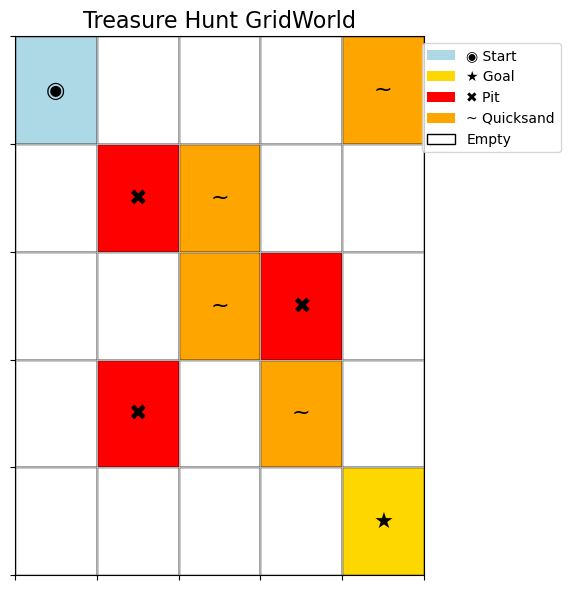

In [50]:
def plot_grid_with_icons(env):
    grid = env.grid
    cmap = {
        0: 'white',      # EMPTY
        1: 'lightblue',  # START
        2: 'gold',       # GOAL
        3: 'red',        # PIT
        4: 'orange'      # QUICKSAND
    }

    icon_map = {
            0: '',     # Empty
            1: '◉',    # Start (large circle)
            2: '★',    # Goal (star)
            3: '✖',    # Pit (X)
            4: '~'     # Quicksand (wave)
}


    fig, ax = plt.subplots(figsize=(6, 6))
    for i in range(GRID_HEIGHT):
        for j in range(GRID_WIDTH):
            cell_type = grid[i, j]
            rect = plt.Rectangle((j, GRID_HEIGHT - i - 1), 1, 1,
                                 facecolor=cmap[cell_type], edgecolor='black')
            ax.add_patch(rect)
            ax.text(j + 0.5, GRID_HEIGHT - i - 0.5, icon_map[cell_type],
                    ha='center', va='center', fontsize=16)

    ax.set_xlim(0, GRID_WIDTH)
    ax.set_ylim(0, GRID_HEIGHT)
    ax.set_xticks(np.arange(0, GRID_WIDTH + 1, 1))
    ax.set_yticks(np.arange(0, GRID_HEIGHT + 1, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title("Treasure Hunt GridWorld", fontsize=16)
    ax.grid(True)

    # Emoji legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='lightblue', label='◉ Start'),
        Patch(facecolor='gold', label='★ Goal'),
        Patch(facecolor='red', label='✖ Pit'),
        Patch(facecolor='orange', label='~ Quicksand'),
        Patch(facecolor='white', edgecolor='black', label='Empty')
    ]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.35, 1))
    plt.tight_layout()
    plt.show()

# Run the plot with icons
plot_grid_with_icons(env)


## Task 2: Define State Transition Function and Reward Function

### 🔁 State Transition Function

The agent moves on a 5×5 grid based on discrete actions:

- `'U'` = Up, `'D'` = Down, `'L'` = Left, `'R'` = Right

The environment enforces the following rules:
- Movement is **bounded by the grid** (cannot move outside).
- Each action deterministically leads to a new state (if within bounds).
- The new state is returned, along with the **corresponding reward** and a `done` flag if the episode ends.

---

### 💰 Reward Function

Each grid cell has a type that determines the agent's reward:

| Cell Type   | Description               | Reward | Terminal |
|-------------|---------------------------|--------|----------|
| Empty       | Safe but costly           | -0.5   | ❌       |
| Quicksand   | Non-terminal hazard       | -5     | ❌       |
| Pit         | Deadly trap               | -15    | ✅       |
| Goal        | Treasure (objective)      | +100   | ✅       |

This setup rewards:
- **Risk-aware navigation**
- **Path length minimization**
- **Avoidance of hazardous shortcuts**

**Table 1: Reward Function for Each Grid Cell Type**

| Cell Type      | Symbol | Description            | Reward | Terminal |
|----------------|--------|------------------------|--------|----------|
| Start          | S      | Starting cell          | 0      | No       |
| Goal           | G      | Treasure chest         | +100   | Yes      |
| Pit            | P      | Deadly trap            | -15    | Yes      |
| Quicksand      | Q      | Slows movement         | -5     | No       |
| Empty Cell     | –      | Normal path            | -0.5   | No       |


## Task 3: Set up Q-Learning Parameters and Policy

To train our pirate agent using Q-learning, we define a set of core hyperparameters and an exploration strategy that evolves over time.

### 🔧 Q-Learning Hyperparameters

- **Learning rate (α)**: Controls how quickly the agent updates its Q-values.
  - We set **α = 0.1** for moderately paced learning.
  
- **Discount factor (γ)**: Determines how much future rewards influence current decisions.
  - We use **γ = 0.9**, encouraging the agent to pursue long-term treasure over immediate gain.
  
- **Exploration rate (ε)**: Governs the trade-off between exploration and exploitation.
  - Instead of a fixed value, we implement **ε decay**, starting with **ε = 1.0** and reducing it gradually to **ε_min = 0.05** using a **decay rate of 0.995**.
  - This allows the agent to explore more during early episodes and exploit learned knowledge later in training.

These values will be tuned systematically in **Task 5** through grid search to observe their effects on learning performance.

---

### 🎯 ε-Greedy Policy with Decay

The agent selects actions using the ε-greedy strategy:
- With probability **ε**, it takes a **random action** (exploration),
- With probability **1−ε**, it selects the **action with the highest Q-value** (exploitation),
- Ties among best actions are broken randomly.

The value of **ε decays after each episode**, allowing the agent to shift from exploration to exploitation over time.

In [51]:
# Q-table initialization
Q = {
    (i, j): {a: 0.0 for a in ACTIONS}
    for i in range(GRID_HEIGHT)
    for j in range(GRID_WIDTH)
}

# Q-learning parameters
alpha = 0.1              # Learning rate
gamma = 0.9              # Discount factor
epsilon = 1.0            # Initial exploration rate
epsilon_decay = 0.995    # Decay rate per episode
epsilon_min = 0.05       # Minimum exploration

def choose_action(state, Q, epsilon):
    if np.random.rand() < epsilon:
        return random.choice(ACTIONS)
    else:
        q_vals = Q[state]
        max_q = max(q_vals.values())
        best_actions = [a for a, v in q_vals.items() if v == max_q]
        return random.choice(best_actions)


## Task 4: Run the Q-learning Algorithm and Represent Its Performance

We now train our Q-learning agent using the baseline configuration:

- **α = 0.1** (learning rate)
- **γ = 0.9** (discount factor)
- **ε = 1.0** initially, with **decay rate = 0.995** down to a **minimum of 0.05**

---

### 🔁 Q-learning Training Loop

For each episode:
1. The agent starts from the initial state,
2. It selects actions using the **ε-greedy strategy** with decaying ε,
3. Q-values are updated using the Bellman equation,
4. The total reward is recorded,
5. ε is decayed at the end of each episode.

We train the agent over **1,000 episodes** and visualize learning using a **moving average** of total rewards to assess convergence and policy quality.

In [52]:
def run_q_learning(alpha, gamma, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.05, episodes=500, max_steps=100):
    Q_local = {
        (i, j): {a: 0.0 for a in ACTIONS}
        for i in range(GRID_HEIGHT)
        for j in range(GRID_WIDTH)
    }
    rewards = []

    for ep in range(episodes):
        state = env.reset()
        total_reward = 0

        for _ in range(max_steps):
            action = choose_action(state, Q_local, epsilon)
            next_state, reward, done = env.step(action)

            # Q-learning update rule
            old_q = Q_local[state][action]
            next_max = max(Q_local[next_state].values())
            Q_local[state][action] = old_q + alpha * (reward + gamma * next_max - old_q)

            state = next_state
            total_reward += reward
            if done:
                break

        rewards.append(total_reward)

        # ε decay
        if epsilon > epsilon_min:
            epsilon = max(epsilon * epsilon_decay, epsilon_min)

    return Q_local, rewards

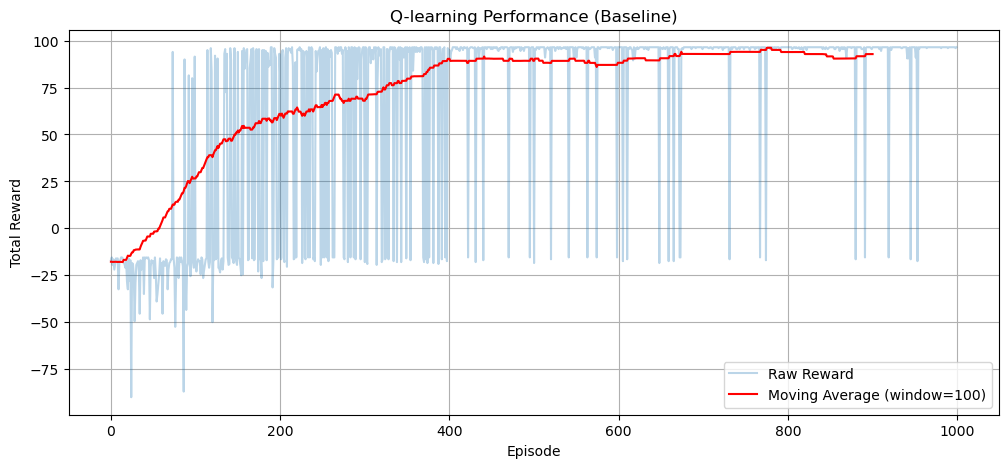

In [53]:
# Run baseline experiment
Q_baseline, rewards_baseline = run_q_learning(
    alpha=0.1,
    gamma=0.9,
    epsilon=1.0,
    epsilon_decay=0.995,
    epsilon_min=0.05,
    episodes=1000
)

# Moving average
def moving_avg(data, window=100):
    return np.convolve(data, np.ones(window)/window, mode='valid')

# Plot learning curve
plt.figure(figsize=(12, 5))
plt.plot(rewards_baseline, alpha=0.3, label='Raw Reward')
plt.plot(moving_avg(rewards_baseline), label='Moving Average (window=100)', color='red')
plt.title("Q-learning Performance (Baseline)")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.legend()
plt.show()


## Task 5: Experiment with Different Parameter Values and Policies

We now conduct a structured hyperparameter search to evaluate how different learning settings and action selection policies affect the agent’s performance.

---

### 🔧 ε-Greedy Policy (with ε-decay)

We perform a full grid search over the following parameters:

- **Learning rate (α)** ∈ {0.1, 0.3, 0.5}
- **Discount factor (γ)** ∈ {0.7, 0.9}
- **Initial exploration rate (ε)** ∈ {0.1, 0.3, 0.5}

This results in **18 configurations**. Instead of using a fixed ε, we apply an **ε-decay strategy**:
- ε is initialized to one of the values above,
- It decays after each episode using a decay factor of **0.995**,
- It reaches a **minimum threshold ε_min = 0.05**.

This allows the agent to explore aggressively early in training and exploit more confidently later.

---

### 🔁 Softmax (Boltzmann) Policy

We also experiment with a **temperature-based softmax policy**, which selects actions probabilistically based on their Q-values:

- **Learning rate (α)** ∈ {0.1, 0.3}
- **Discount factor (γ)** ∈ {0.7, 0.9}
- **Temperature (τ)** ∈ {0.5, 1.0, 2.0}

This results in **12 configurations**.

Softmax does not use ε. Instead, **τ controls exploration**:
- High τ → more exploration (flatter probabilities),
- Low τ → greedier decisions (sharper probabilities).

---

### 🧪 Experiment Setup

- Each configuration is trained for **1000 episodes**,
- We record the **total reward per episode**,
- We compute the **average reward and standard deviation** over the **last 100 episodes**,
- We compare the **top 5 runs** of each policy type based on final average reward,
- We visualize the learning curves to assess convergence and stability.

---

### 📊 Results Breakdown

We divide results into two groups for comparison:
- **ε-Greedy Results**: top configurations using decaying ε
- **Softmax Results**: top configurations using τ-controlled exploration

This structure allows us to clearly interpret how each exploration strategy behaves across hyperparameter settings.

In [77]:
import time

### Softmax Action Policy

In [78]:
import math

def softmax_action_selection(state, Q, temperature=1.0):
    q_vals = Q[state]
    max_q = max(q_vals.values())  # for numerical stability
    exp_q = {a: math.exp((q - max_q) / temperature) for a, q in q_vals.items()}
    sum_exp = sum(exp_q.values())
    probs = [exp_q[a] / sum_exp for a in ACTIONS]
    return np.random.choice(ACTIONS, p=probs)

### Q-learning Runner

In [79]:
def run_q_learning(alpha, gamma, epsilon=None, temperature=None, use_softmax=False,
                   epsilon_decay=None, epsilon_min=0.05,
                   episodes=1000, max_steps=100):
    Q_local = {(i, j): {a: 0.0 for a in ACTIONS}
               for i in range(GRID_HEIGHT) for j in range(GRID_WIDTH)}
    rewards = []

    for ep in range(episodes):
        state = env.reset()
        total_reward = 0

        for _ in range(max_steps):
            if use_softmax:
                action = softmax_action_selection(state, Q_local, temperature)
            else:
                if np.random.rand() < epsilon:
                    action = random.choice(ACTIONS)
                else:
                    max_q = max(Q_local[state].values())
                    best_actions = [a for a, v in Q_local[state].items() if v == max_q]
                    action = random.choice(best_actions)

            next_state, reward, done = env.step(action)

            # Q update
            old_q = Q_local[state][action]
            next_max = max(Q_local[next_state].values())
            Q_local[state][action] = old_q + alpha * (reward + gamma * next_max - old_q)

            state = next_state
            total_reward += reward
            if done:
                break

        rewards.append(total_reward)

        # Apply ε decay only if using ε-greedy
        if not use_softmax and epsilon_decay is not None:
            epsilon = max(epsilon * epsilon_decay, epsilon_min)

    return Q_local, rewards

### Run All Configurations

In [80]:
# ε-Greedy configurations
alphas = [0.1, 0.3, 0.5]
gammas = [0.7, 0.9]
epsilons = [0.1, 0.3, 0.5]

# Softmax configurations
temperatures = [0.5, 1.0, 2.0]
softmax_alphas = [0.1, 0.3]
softmax_gammas = [0.7, 0.9]

# Storage
results = []
curves = {}

# ε-Greedy runs
for alpha in alphas:
    for gamma in gammas:
        for epsilon in epsilons:
            label = f"ε-greedy α={alpha}, γ={gamma}, ε={epsilon}"
            start = time.time()
            _, rewards = run_q_learning(alpha, gamma, epsilon=epsilon, epsilon_decay=0.995, epsilon_min=0.05)
            duration = time.time() - start
            avg = np.mean(rewards[-100:])
            std = np.std(rewards[-100:])
            results.append({'label': label, 'alpha': alpha, 'gamma': gamma, 'epsilon': epsilon,
                            'policy': 'ε-greedy', 'avg_reward': avg, 'std_dev': std, 'duration_sec': duration})
            curves[label] = rewards

# Softmax runs
for alpha in softmax_alphas:
    for gamma in softmax_gammas:
        for tau in temperatures:
            label = f"Softmax α={alpha}, γ={gamma}, τ={tau}"
            start = time.time()
            _, rewards = run_q_learning(alpha, gamma, use_softmax=True, temperature=tau)
            duration = time.time() - start
            avg = np.mean(rewards[-100:])
            std = np.std(rewards[-100:])
            results.append({'label': label, 'alpha': alpha, 'gamma': gamma, 'temperature': tau,
                            'policy': 'softmax', 'avg_reward': avg, 'std_dev': std, 'duration_sec': duration})
            curves[label] = rewards

### Summary Table

In [88]:
df_all = pd.DataFrame(results)
df_all_sorted = df_all.sort_values(by="avg_reward", ascending=False).reset_index(drop=True)
df_all_sorted.head(10)  # show top 10 configurations

,label,alpha,gamma,epsilon,policy,avg_reward,std_dev,duration_sec,temperature
0,"Softmax α=0.3, γ=0.9, τ=2.0",0.3,0.9,NaN,softmax,96.500,0.000000,0.338483,2.0
1,"Softmax α=0.3, γ=0.9, τ=0.5",0.3,0.9,NaN,softmax,96.500,0.000000,0.307287,0.5
2,"Softmax α=0.3, γ=0.7, τ=0.5",0.3,0.7,NaN,softmax,96.500,0.000000,0.262045,0.5
3,"Softmax α=0.1, γ=0.9, τ=2.0",0.1,0.9,NaN,softmax,96.500,0.000000,0.297199,2.0
4,"Softmax α=0.1, γ=0.9, τ=1.0",0.1,0.9,NaN,softmax,96.500,0.000000,0.265563,1.0
5,"Softmax α=0.1, γ=0.9, τ=0.5",0.1,0.9,NaN,softmax,96.500,0.000000,0.262385,0.5
6,"Softmax α=0.1, γ=0.7, τ=1.0",0.1,0.7,NaN,softmax,96.500,0.000000,0.264041,1.0
7,"Softmax α=0.3, γ=0.9, τ=1.0",0.3,0.9,NaN,softmax,96.500,0.000000,0.320457,1.0
8,"Softmax α=0.1, γ=0.7, τ=0.5",0.1,0.7,NaN,softmax,96.500,0.000000,0.249940,0.5
9,"Softmax α=0.3, γ=0.7, τ=1.0",0.3,0.7,NaN,softmax,96.465,0.127574,0.264058,1.0


### Plot Best Learning Curves

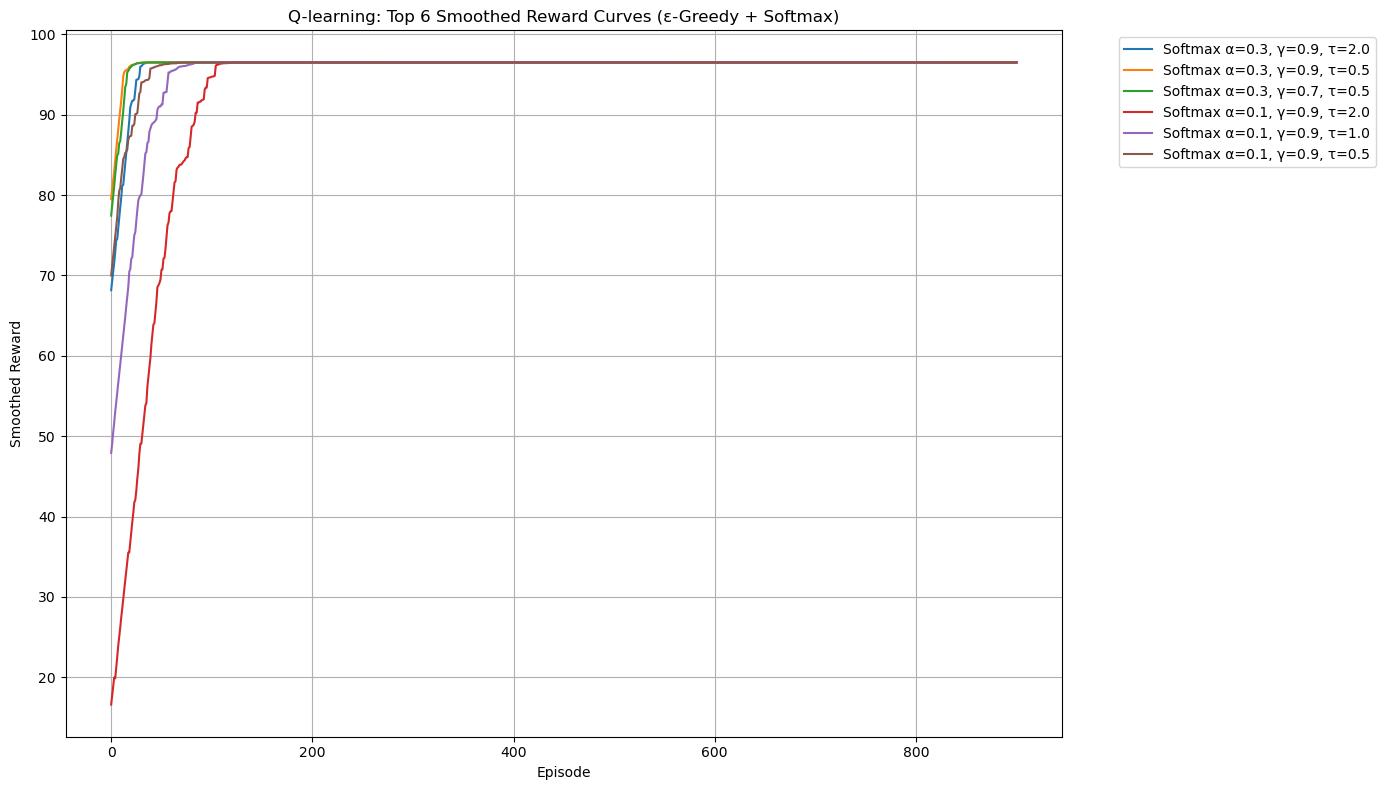

In [82]:
plt.figure(figsize=(14, 8))
top_labels = df_all_sorted['label'].head(6)

for label in top_labels:
    smoothed = moving_avg(curves[label])
    plt.plot(smoothed, label=label)

plt.title("Q-learning: Top 6 Smoothed Reward Curves (ε-Greedy + Softmax)")
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 🔍 Separate Comparison of ε-Greedy and Softmax Policies

To better understand the impact of different exploration strategies, we divide the experiments into two groups:

---

#### ε-Greedy Policy
- Grid search over:
  - α ∈ {0.1, 0.3, 0.5}
  - γ ∈ {0.7, 0.9}
  - ε ∈ {0.1, 0.3, 0.5}
- Total combinations: 18

---

#### Softmax Policy
- Grid search over:
  - α ∈ {0.1, 0.3}
  - γ ∈ {0.7, 0.9}
  - τ ∈ {0.5, 1.0, 2.0}
- Total combinations: 12

We now present their results **independently** to compare performance, convergence, and stability within each policy family.

In [83]:
# Split results
df_eps = df_all[df_all['policy'] == 'ε-greedy'].sort_values(by='avg_reward', ascending=False)
df_soft = df_all[df_all['policy'] == 'softmax'].sort_values(by='avg_reward', ascending=False)

# Show top 5 of each
print("Top ε-Greedy Configurations:")
display(df_eps.head(5))

print("Top Softmax Configurations:")
display(df_soft.head(5))


Top ε-Greedy Configurations:


,label,alpha,gamma,epsilon,policy,avg_reward,std_dev,duration_sec,temperature
5,"ε-greedy α=0.1, γ=0.9, ε=0.5",0.1,0.9,0.5,ε-greedy,94.875,11.325938,0.017785,NaN
16,"ε-greedy α=0.5, γ=0.9, ε=0.3",0.5,0.9,0.3,ε-greedy,94.860,11.442264,0.031243,NaN
3,"ε-greedy α=0.1, γ=0.9, ε=0.1",0.1,0.9,0.1,ε-greedy,94.745,11.453274,0.028100,NaN
4,"ε-greedy α=0.1, γ=0.9, ε=0.3",0.1,0.9,0.3,ε-greedy,93.885,15.704116,0.028958,NaN
8,"ε-greedy α=0.3, γ=0.7, ε=0.5",0.3,0.7,0.5,ε-greedy,93.780,15.769483,0.031250,NaN


Top Softmax Configurations:


,label,alpha,gamma,epsilon,policy,avg_reward,std_dev,duration_sec,temperature
18,"Softmax α=0.1, γ=0.7, τ=0.5",0.1,0.7,NaN,softmax,96.5,0.0,0.249940,0.5
19,"Softmax α=0.1, γ=0.7, τ=1.0",0.1,0.7,NaN,softmax,96.5,0.0,0.264041,1.0
21,"Softmax α=0.1, γ=0.9, τ=0.5",0.1,0.9,NaN,softmax,96.5,0.0,0.262385,0.5
22,"Softmax α=0.1, γ=0.9, τ=1.0",0.1,0.9,NaN,softmax,96.5,0.0,0.265563,1.0
23,"Softmax α=0.1, γ=0.9, τ=2.0",0.1,0.9,NaN,softmax,96.5,0.0,0.297199,2.0


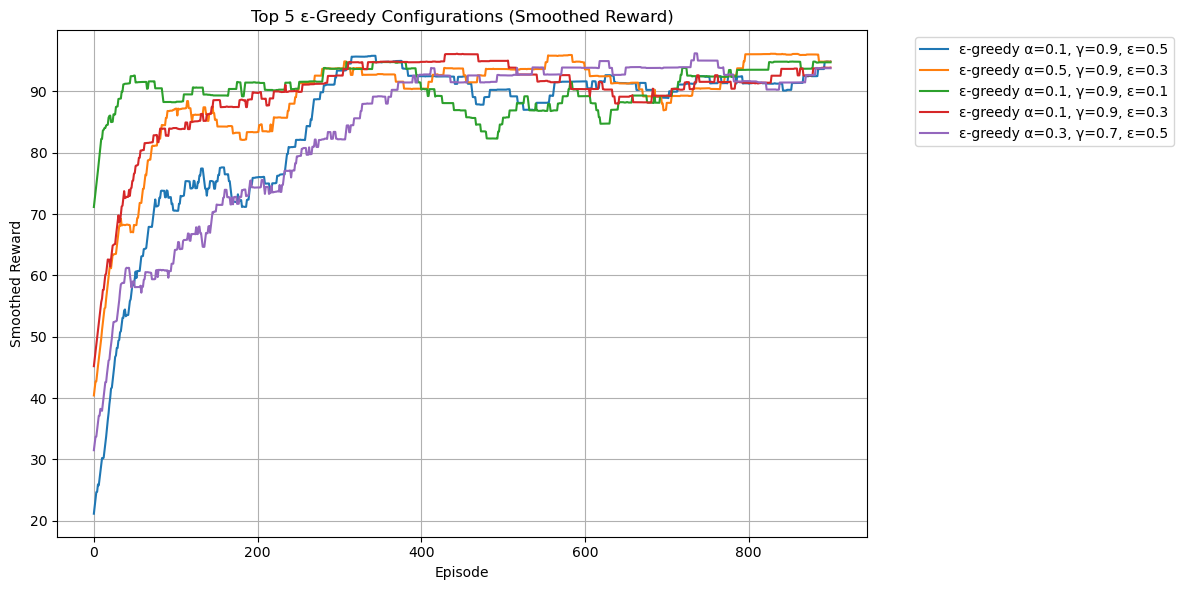

In [84]:
plt.figure(figsize=(12, 6))
for label in df_eps['label'].head(5):
    plt.plot(moving_avg(curves[label]), label=label)

plt.title("Top 5 ε-Greedy Configurations (Smoothed Reward)")
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


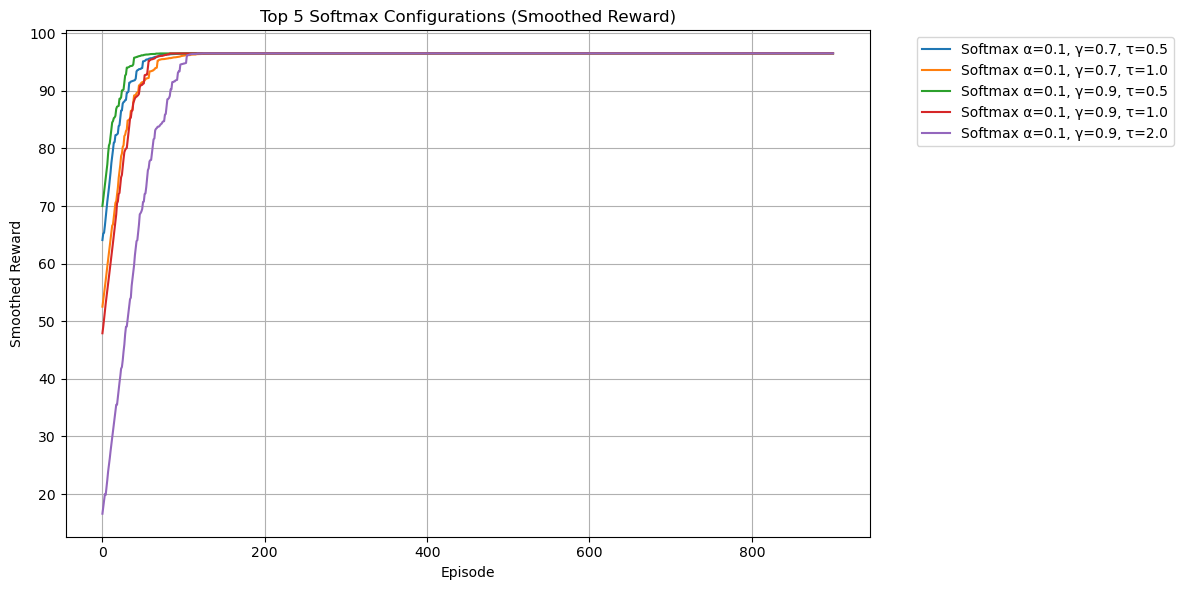

In [85]:
plt.figure(figsize=(12, 6))
for label in df_soft['label'].head(5):
    plt.plot(moving_avg(curves[label]), label=label)

plt.title("Top 5 Softmax Configurations (Smoothed Reward)")
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Task 6: Analyze the Results Quantitatively and Qualitatively

We now analyze the learning outcomes from our grid search across 30 configurations: 18 using ε-greedy (with ε-decay) and 12 using the softmax (Boltzmann) policy.


In [86]:
from IPython.display import display

print("Top 3 ε-Greedy Configurations:")
display(df_eps.head(3)[['label', 'avg_reward', 'std_dev', 'duration_sec']])

print("Top 3 Softmax Configurations:")
display(df_soft.head(3)[['label', 'avg_reward', 'std_dev', 'duration_sec']])

Top 3 ε-Greedy Configurations:


,label,avg_reward,std_dev,duration_sec
5,"ε-greedy α=0.1, γ=0.9, ε=0.5",94.875,11.325938,0.017785
16,"ε-greedy α=0.5, γ=0.9, ε=0.3",94.860,11.442264,0.031243
3,"ε-greedy α=0.1, γ=0.9, ε=0.1",94.745,11.453274,0.028100


Top 3 Softmax Configurations:


,label,avg_reward,std_dev,duration_sec
18,"Softmax α=0.1, γ=0.7, τ=0.5",96.5,0.0,0.249940
19,"Softmax α=0.1, γ=0.7, τ=1.0",96.5,0.0,0.264041
21,"Softmax α=0.1, γ=0.9, τ=0.5",96.5,0.0,0.262385
